In [2]:
import pandas as pd
import numpy as np
# import torch
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
from sklearn import preprocessing

seed = 42

FILENAME = "train_dataset.csv"

df1 = pd.read_csv(FILENAME, encoding='ISO-8859-1', sep=",", low_memory=False)
df1 = df1.dropna()
y = df1["type"]
X = df1.drop(columns=["type", "label"])

err_arr = X.loc[X["src_bytes"] == "0.0.0.0"]        #sostituire con mean
X = X.drop(index=err_arr.index)
y = y.drop(index=err_arr.index)
X.astype({'src_bytes': 'int64', 'ts': 'datetime64[ms]', 'dns_AA': 'bool', 'dns_RD': 'bool', 'dns_RA': 'bool', 'dns_rejected': 'bool', 'ssl_resumed': 'bool', 'ssl_established': 'bool', 'weird_notice': 'bool'}).dtypes

X = X.to_numpy()
y = y.to_numpy()


oe = preprocessing.OrdinalEncoder()
oe.fit(X)
X = oe.transform(X)

le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)


indeces = np.arange(X.shape[0])
train_idx, test_idx = train_test_split(indeces, test_size=0.1, stratify=y, random_state=seed)
# test_idx, val_idx = train_test_split(test_idx, test_size=0.5, stratify=y[test_idx], random_state=seed)

fold = np.zeros(X.shape[0])
fold[train_idx] = -1
# fold[test_idx] = 0
# fold[val_idx] = 1

ps = PredefinedSplit(fold)
ps.get_n_splits()

X_test = X[test_idx,:]
y_test = y[test_idx]
X_train = X[train_idx,:]
y_train = y[train_idx]
# X_val = X[val_idx,:]
# y_val = y[val_idx]

In [3]:
## DOWNSAMPLING
from sklearn.utils import resample

X_balanced = X_train[y_train==4]
y_balanced = y_train[y_train==4]

for i in [0, 1, 2, 3, 5, 6, 7, 8, 9]:
    X_downsampled, y_downsampled = resample(X_train[y_train==i], y_train[y_train==i], replace=False, n_samples=np.sum(y_train==4), random_state=seed)
    X_balanced = np.concatenate((X_balanced, X_downsampled))
    y_balanced = np.concatenate((y_balanced, y_downsampled))

In [4]:
## OVERSAMPLING
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=seed)
X_upsampled, y_upsampled = smote.fit_resample(X_train, y_train)

/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [5]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import decomposition

### --- SCALING ---
## Scaling (downsampling)
scaler = preprocessing.StandardScaler()
scaler.fit(X_balanced)
X_balanced = scaler.transform(X_balanced)
X_bal_test = scaler.transform(X_test)

## Scaling (upsampling)
scaler = preprocessing.StandardScaler()
scaler.fit(X_upsampled)
X_upsampled = scaler.transform(X_upsampled)
X_up_test = scaler.transform(X_test)

scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


### --- PCA ---
## PCA (downsampling)
pca = decomposition.PCA()
pca.fit(X_balanced)
X_balanced_pca = pca.transform(X_balanced)
X_test_bal_pca = pca.transform(X_bal_test)

## PCA (upsampling)
pca = decomposition.PCA()
pca.fit(X_upsampled)
X_upsampled_pca = pca.transform(X_upsampled)
X_test_up_pca = pca.transform(X_up_test)

pca = decomposition.PCA()
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


### ---LDA---
## LDA (downsampling)
lda = LinearDiscriminantAnalysis(n_components=9)
lda.fit(X_balanced, y_balanced)
X_balanced_lda = lda.transform(X_balanced)
X_test_bal_lda = lda.transform(X_bal_test)

## LDA (upsampling)
lda = LinearDiscriminantAnalysis(n_components=9)
lda.fit(X_upsampled, y_upsampled)
X_upsampled_lda = lda.transform(X_upsampled)
X_test_up_lda = lda.transform(X_up_test)

lda = LinearDiscriminantAnalysis(n_components=9)
lda.fit(X_train, y_train)
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)

In [6]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import pickle

K=10 		 Precision: 0.9974 	 Accuracy: 0.9974 	 F1: 0.9974
K=20 		 Precision: 0.9967 	 Accuracy: 0.9967 	 F1: 0.9967
K=50 		 Precision: 0.9944 	 Accuracy: 0.9944 	 F1: 0.9944
K=100 		 Precision: 0.9929 	 Accuracy: 0.9929 	 F1: 0.9929
K=500 		 Precision: 0.9809 	 Accuracy: 0.9812 	 F1: 0.9807
K=775 		 Precision: 0.9769 	 Accuracy: 0.9766 	 F1: 0.9757


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=900 		 Precision: 0.9719 	 Accuracy: 0.9724 	 F1: 0.9712


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=1000 		 Precision: 0.9701 	 Accuracy: 0.9706 	 F1: 0.9693


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=1500 		 Precision: 0.9619 	 Accuracy: 0.9643 	 F1: 0.9623


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=2000 		 Precision: 0.9572 	 Accuracy: 0.9600 	 F1: 0.9576

With K=10 there is the best F1 score,


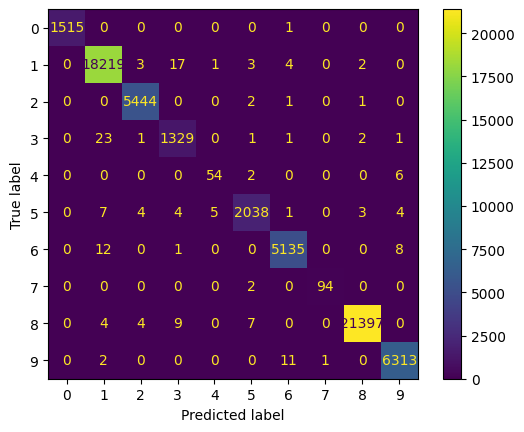

In [6]:
best_f1 = 0
best_model = None
best_y = None

## KNN
X_train = X_train
X_test = X_test
y_train = y_train

for k in [10,20,50,100,500,775,900,1000,1500,2000]:
    clf_in = KNeighborsClassifier(n_neighbors=k)
    clf_in.fit(X_train, y_train)

    y_pred = clf_in.predict(X_test)

    prec = precision_score(y_test, y_pred, average='weighted')
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    if f1 > best_f1:
        best_f1 = f1
        best_model = clf_in
        best_y = y_pred

    print("K={:d} \t\t Precision: {:.4f} \t Accuracy: {:.4f} \t F1: {:.4f}".format(k, prec, acc, f1))

print("\nWith K={:d} there is the best F1 score,".format(best_model.n_neighbors))
cm = confusion_matrix(y_test, best_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot()

K=10 		 Precision: 0.9715 	 Accuracy: 0.9652 	 F1: 0.9672
K=20 		 Precision: 0.9498 	 Accuracy: 0.9421 	 F1: 0.9445
K=50 		 Precision: 0.9206 	 Accuracy: 0.9062 	 F1: 0.9112
K=100 		 Precision: 0.9053 	 Accuracy: 0.8813 	 F1: 0.8887
K=500 		 Precision: 0.8100 	 Accuracy: 0.7005 	 F1: 0.7140


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=775 		 Precision: 0.7298 	 Accuracy: 0.6184 	 F1: 0.6284


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=900 		 Precision: 0.7315 	 Accuracy: 0.6258 	 F1: 0.6385


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=1000 		 Precision: 0.7270 	 Accuracy: 0.5975 	 F1: 0.6143


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=1500 		 Precision: 0.7192 	 Accuracy: 0.4659 	 F1: 0.4951


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=2000 		 Precision: 0.6652 	 Accuracy: 0.4207 	 F1: 0.4374

With K=10 there is the best F1 score,


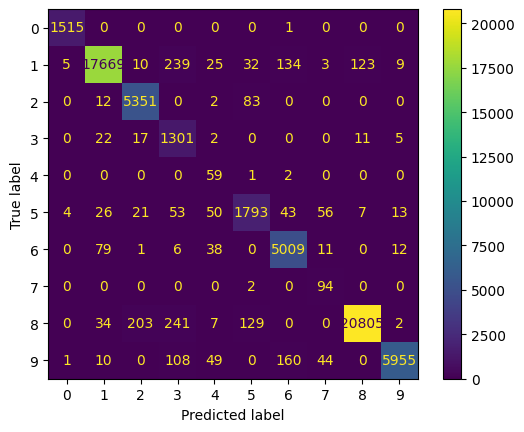

In [7]:
best_f1_down = 0
best_model_down = None
best_y_down = None

## KNN (downsampling)
X_train = X_balanced
X_test = X_bal_test
y_train = y_balanced

for k in [10,20,50,100,500,775,900,1000,1500,2000]:
    clf_in = KNeighborsClassifier(n_neighbors=k)
    clf_in.fit(X_train, y_train)

    y_pred = clf_in.predict(X_test)

    prec = precision_score(y_test, y_pred, average='weighted')
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    if f1 > best_f1_down:
        best_f1_down = f1
        best_model_down = clf_in
        best_y_down = y_pred

    print("K={:d} \t\t Precision: {:.4f} \t Accuracy: {:.4f} \t F1: {:.4f}".format(k, prec, acc, f1))

print("\nWith K={:d} there is the best F1 score,".format(best_model_down.n_neighbors))
cm = confusion_matrix(y_test, best_y_down)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot()

K=10 		 Precision: 0.9976 	 Accuracy: 0.9975 	 F1: 0.9975
K=20 		 Precision: 0.9967 	 Accuracy: 0.9966 	 F1: 0.9966
K=50 		 Precision: 0.9952 	 Accuracy: 0.9949 	 F1: 0.9950
K=100 		 Precision: 0.9933 	 Accuracy: 0.9928 	 F1: 0.9929
K=500 		 Precision: 0.9873 	 Accuracy: 0.9848 	 F1: 0.9856
K=775 		 Precision: 0.9852 	 Accuracy: 0.9822 	 F1: 0.9831
K=900 		 Precision: 0.9845 	 Accuracy: 0.9811 	 F1: 0.9821
K=1000 		 Precision: 0.9838 	 Accuracy: 0.9804 	 F1: 0.9814
K=1500 		 Precision: 0.9816 	 Accuracy: 0.9776 	 F1: 0.9788
K=2000 		 Precision: 0.9788 	 Accuracy: 0.9740 	 F1: 0.9755

With K=2000 there is the best F1 score,


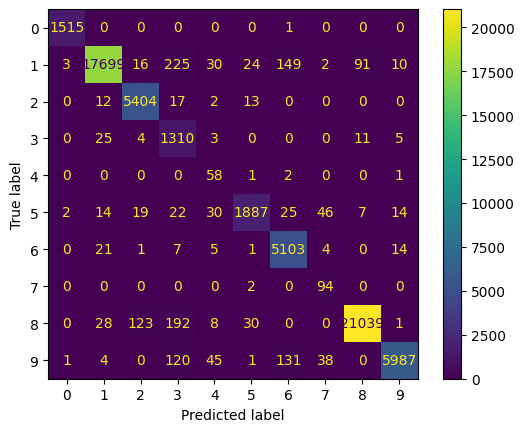

In [8]:
best_f1_up = 0
best_model_up = None
best_y_up = None

## KNN (upsampling)
X_train = X_upsampled
X_test = X_up_test
y_train = y_upsampled

for k in [10,20,50,100,500,775,900,1000,1500,2000]:
    clf_in = KNeighborsClassifier(n_neighbors=k)
    clf_in.fit(X_train, y_train)

    y_pred = clf_in.predict(X_test)

    prec = precision_score(y_test, y_pred, average='weighted')
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    if f1 > best_f1_up:
        best_f1_down = f1
        best_model_up = clf_in
        best_y_up = y_pred

    print("K={:d} \t\t Precision: {:.4f} \t Accuracy: {:.4f} \t F1: {:.4f}".format(k, prec, acc, f1))


print("\nWith K={:d} there is the best F1 score,".format(best_model_up.n_neighbors))
cm = confusion_matrix(y_test, best_y_up)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot()

In [9]:
from sklearn.svm import SVC
from sklearn import svm

In [10]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10, 100, 1000],  
}  

grid = GridSearchCV(svm.LinearSVC(random_state=seed), param_grid, verbose=10, cv=ps, scoring='f1_weighted', n_jobs=-1)
grid.fit(X, y)
file = open("svm.save", "wb")
pickle.dump(grid.best_estimator_, file)
print("Best hyper: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)
file.close()

Fitting 1 folds for each of 10 candidates, totalling 10 fits
[CV 1/1; 5/10] START C=10, penalty=l1...........................................
[CV 1/1; 1/10] START C=0.1, penalty=l1..........................................
[CV 1/1; 6/10] START C=10, penalty=l2...........................................
[CV 1/1; 3/10] START C=1, penalty=l1............................................
[CV 1/1; 8/10] START C=100, penalty=l2..........................................
[CV 1/1; 7/10] START C=100, penalty=l1..........................................
[CV 1/1; 4/10] START C=1, penalty=l2............................................
[CV 1/1; 2/10] START C=0.1, penalty=l2..........................................
[CV 1/1; 6/10] END ............C=10, penalty=l2;, score=0.915 total time= 2.3min
[CV 1/1; 9/10] START C=1000, penalty=l1.........................................
[CV 1/1; 4/10] END .............C=1, penalty=l2;, score=0.911 total time= 2.7min
[CV 1/1; 8/10] END ...........C=100, penalty=l2;

/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/1; 3/10] END .............C=1, penalty=l1;, score=0.946 total time=12.6min


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/1; 5/10] END ............C=10, penalty=l1;, score=0.946 total time=12.7min


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/1; 1/10] END ...........C=0.1, penalty=l1;, score=0.946 total time=12.8min


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/1; 7/10] END ...........C=100, penalty=l1;, score=0.946 total time=12.9min


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/1; 9/10] END ..........C=1000, penalty=l1;, score=0.946 total time=11.1min
Best hyper:  LinearSVC(C=100, penalty='l1', random_state=42)
Best score:  0.9464010828888144


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [12]:
## RandomForest
rf = RandomForestClassifier()
n_estimators = [5, 10, 20, 50, 100, 200, 500]
criterion = ["gini", "entropy"]
max_depth = [1, 2, 5, 10, 20, 50]
random_grid = {'n_estimators': n_estimators,
               'criterion': criterion,
               'max_depth' : max_depth
              }
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=200, cv=ps, verbose=10, random_state=seed, scoring='f1_weighted', n_jobs=-1)
rf_random.fit(X, np.ravel(y))
file = open("rf.save", "wb")
pickle.dump(rf_random.best_estimator_, file)
print("Best hyper: ", rf_random.best_estimator_)
print("Best score: ", rf_random.best_score_)
file.close()

Fitting 1 folds for each of 84 candidates, totalling 84 fits


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 84 is smaller than n_iter=200. Running 84 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 1/1; 5/84] START criterion=gini, max_depth=1, n_estimators=100..............
[CV 1/1; 3/84] START criterion=gini, max_depth=1, n_estimators=20...............
[CV 1/1; 7/84] START criterion=gini, max_depth=1, n_estimators=500..............
[CV 1/1; 4/84] START criterion=gini, max_depth=1, n_estimators=50...............
[CV 1/1; 2/84] START criterion=gini, max_depth=1, n_estimators=10...............
[CV 1/1; 1/84] START criterion=gini, max_depth=1, n_estimators=5................
[CV 1/1; 6/84] START criterion=gini, max_depth=1, n_estimators=200..............
[CV 1/1; 8/84] START criterion=gini, max_depth=2, n_estimators=5................
[CV 1/1; 1/84] END criterion=gini, max_depth=1, n_estimators=5;, score=0.485 total time=   3.1s
[CV 1/1; 9/84] START criterion=gini, max_depth=2, n_estimators=10...............
[CV 1/1; 8/84] END criterion=gini, max_depth=2, n_estimators=5;, score=0.538 total time=   4.4s
[CV 1/1; 10/84] START criterion=gini, max_depth=2, n_estimators=20.............

---

K=10 		 Precision: 0.9974 	 Accuracy: 0.9974 	 F1: 0.9974
K=20 		 Precision: 0.9967 	 Accuracy: 0.9967 	 F1: 0.9967
K=50 		 Precision: 0.9944 	 Accuracy: 0.9944 	 F1: 0.9944
K=100 		 Precision: 0.9929 	 Accuracy: 0.9929 	 F1: 0.9929
K=500 		 Precision: 0.9809 	 Accuracy: 0.9812 	 F1: 0.9807
K=775 		 Precision: 0.9769 	 Accuracy: 0.9766 	 F1: 0.9757


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=900 		 Precision: 0.9719 	 Accuracy: 0.9724 	 F1: 0.9712


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=1000 		 Precision: 0.9701 	 Accuracy: 0.9706 	 F1: 0.9693


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=1500 		 Precision: 0.9619 	 Accuracy: 0.9643 	 F1: 0.9623

With K=10 there is the best F1 score,


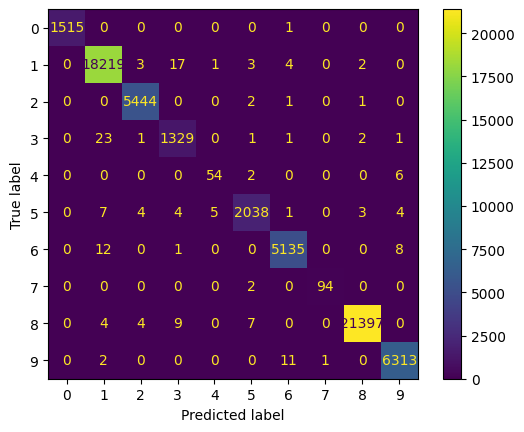

In [8]:
best_f1 = 0
best_model = None
best_y = None

## KNN
X_train = X_train
X_test = X_test
y_train = y_train

for k in [10,20,50,100,500,775,900,1000,1500]:
    clf_in = KNeighborsClassifier(n_neighbors=k)
    clf_in.fit(X_train, y_train)

    y_pred = clf_in.predict(X_test)

    prec = precision_score(y_test, y_pred, average='weighted')
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    if f1 > best_f1:
        best_f1 = f1
        best_model = clf_in
        best_y = y_pred

    print("K={:d} \t\t Precision: {:.4f} \t Accuracy: {:.4f} \t F1: {:.4f}".format(k, prec, acc, f1))

print("\nWith K={:d} there is the best F1 score,".format(best_model.n_neighbors))
cm = confusion_matrix(y_test, best_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot()

In [1]:
import pandas as pd
import numpy as np
# import torch
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
from sklearn import preprocessing

seed = 42

FILENAME = "train_dataset.csv"

# 1. read_csv
# 2. dropna
# 3. drop label
# 4. replace src_bytes
# 5. casting 
# 6. encoding (cat/num)
# 7. extract y 
# 8. drop type
# 9. label encoding on y
 
 #elenco balanced accuracy
# grid come fa a prerpocessare
# linearsvc
df1 = pd.read_csv(FILENAME, encoding='ISO-8859-1', sep=",", low_memory=False)
df1 = df1.dropna()
y = df1["type"]
X = df1.drop(columns=["type", "label"])

err_arr = X.loc[X["src_bytes"] == "0.0.0.0"]
X = X.drop(index=err_arr.index)
y = y.drop(index=err_arr.index)

X.astype({'src_bytes': 'int64', 'ts': 'datetime64[ms]', 'dns_AA': 'bool', 'dns_RD': 'bool', 'dns_RA': 'bool', 'dns_rejected': 'bool', 'ssl_resumed': 'bool', 'ssl_established': 'bool', 'weird_notice': 'bool'}).dtypes

# X = X.to_numpy()
y = y.to_numpy()

X_cat = X.select_dtypes(include=['object'])
X_num = X.select_dtypes(exclude=['object'])
oe = preprocessing.OrdinalEncoder()
oe.fit(X_cat)
X_cat = oe.transform(X_cat)
X = np.concatenate((X_cat, X_num), axis=1)
print(X.shape)


oe = preprocessing.OrdinalEncoder()
oe.fit(X)
X = oe.transform(X)

le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)


indeces = np.arange(X.shape[0])
train_idx, test_idx = train_test_split(indeces, test_size=0.2, stratify=y, random_state=seed)
test_idx, val_idx = train_test_split(test_idx, test_size=0.5, stratify=y[test_idx], random_state=seed)

fold = np.zeros(X.shape[0])
fold[train_idx] = -1
fold[test_idx] = 0
fold[val_idx] = 1

ps = PredefinedSplit(fold)
ps.get_n_splits()

X_test = X[test_idx,:]
y_test = y[test_idx]
X_train = X[train_idx,:]
y_train = y[train_idx]
X_val = X[val_idx,:]
y_val = y[val_idx]

(616983, 44)


In [3]:
from sklearn import decomposition

scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

pca = decomposition.PCA()
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
X_val_pca = pca.transform(X_val)

In [4]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import pickle

In [5]:
from sklearn.metrics import balanced_accuracy_score
best_f1 = 0
best_model = None
best_y = None

## KNN
X_train = X_train_pca
X_test = X_test_pca
y_train = y_train

for k in [10,20,50,100,500,775,900,1000,1500]:
    clf_in = KNeighborsClassifier(n_neighbors=k)
    clf_in.fit(X_train, y_train)

    y_pred = clf_in.predict(X_test)

    prec = precision_score(y_test, y_pred, average='weighted')
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    balanced = balanced_accuracy_score(y_test, y_pred)

    if f1 > best_f1:
        best_f1 = f1
        best_model = clf_in
        best_y = y_pred

    print("K={:d} \t\t Precision: {:.4f} \t Accuracy: {:.4f} \t F1: {:.4f} \t bal: {:.4f}".format(k, prec, acc, f1, balanced))

print("\nWith K={:d} there is the best F1 score,".format(best_model.n_neighbors))
# cm = confusion_matrix(y_test, best_y)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
# disp.plot()

K=10 		 Precision: 0.9976 	 Accuracy: 0.9976 	 F1: 0.9976 	 bal: 0.9768
K=20 		 Precision: 0.9968 	 Accuracy: 0.9968 	 F1: 0.9968 	 bal: 0.9711
K=50 		 Precision: 0.9944 	 Accuracy: 0.9944 	 F1: 0.9944 	 bal: 0.9385
K=100 		 Precision: 0.9930 	 Accuracy: 0.9931 	 F1: 0.9931 	 bal: 0.9327
K=500 		 Precision: 0.9806 	 Accuracy: 0.9810 	 F1: 0.9805 	 bal: 0.8340


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=775 		 Precision: 0.9763 	 Accuracy: 0.9769 	 F1: 0.9760 	 bal: 0.7890


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=900 		 Precision: 0.9725 	 Accuracy: 0.9729 	 F1: 0.9717 	 bal: 0.7734


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=1000 		 Precision: 0.9706 	 Accuracy: 0.9711 	 F1: 0.9698 	 bal: 0.7667
K=1500 		 Precision: 0.9620 	 Accuracy: 0.9644 	 F1: 0.9623 	 bal: 0.7373

With K=10 there is the best F1 score,


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       758
           1       1.00      1.00      1.00      9125
           2       1.00      1.00      1.00      2724
           3       0.97      0.97      0.97       679
           4       0.97      0.94      0.95        31
           5       0.99      0.99      0.99      1033
           6       1.00      1.00      1.00      2578
           7       1.00      0.96      0.98        48
           8       1.00      1.00      1.00     10711
           9       1.00      1.00      1.00      3163

    accuracy                           1.00     30850
   macro avg       0.99      0.98      0.99     30850
weighted avg       1.00      1.00      1.00     30850



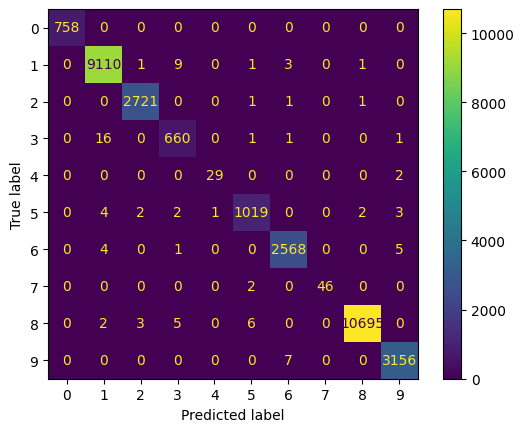

In [6]:
from sklearn.metrics import classification_report


y_pred = best_model.predict(X_val_pca)
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot()
print(classification_report(y_val, y_pred))